In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
import umap
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA

Using backend: pytorch


In [3]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='../../data/dataset_dgl')
graph = dataset[0][0]

In [4]:
output_emb_file = '../../models/graphsage_link_pred/full_cos_graphsage_linkpred_05_h.npy'

In [5]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 50)

## L2 Distance

In [6]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [7]:
index.train(embeddings)
index.add(embeddings)

In [8]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7fa493816990> >

In [9]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [10]:
distances, indices = index.search(embeddings, 2)

In [11]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(23542)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [13]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [14]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [15]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

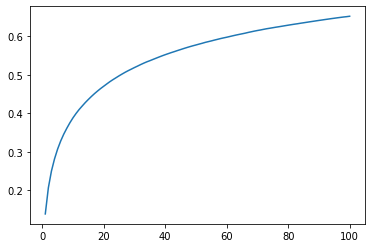

In [16]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [17]:
percentages

tensor([0.1390, 0.2068, 0.2501, 0.2816, 0.3070, 0.3279, 0.3457, 0.3611, 0.3753,
        0.3881, 0.3994, 0.4096, 0.4187, 0.4276, 0.4358, 0.4435, 0.4508, 0.4576,
        0.4641, 0.4701, 0.4760, 0.4818, 0.4871, 0.4921, 0.4971, 0.5018, 0.5063,
        0.5105, 0.5145, 0.5185, 0.5222, 0.5261, 0.5298, 0.5332, 0.5362, 0.5395,
        0.5427, 0.5458, 0.5489, 0.5518, 0.5546, 0.5573, 0.5599, 0.5626, 0.5651,
        0.5677, 0.5702, 0.5726, 0.5749, 0.5770, 0.5792, 0.5814, 0.5837, 0.5856,
        0.5876, 0.5897, 0.5916, 0.5936, 0.5954, 0.5971, 0.5990, 0.6009, 0.6027,
        0.6043, 0.6060, 0.6076, 0.6095, 0.6113, 0.6130, 0.6145, 0.6159, 0.6176,
        0.6191, 0.6204, 0.6217, 0.6231, 0.6243, 0.6257, 0.6270, 0.6284, 0.6296,
        0.6309, 0.6321, 0.6334, 0.6346, 0.6358, 0.6371, 0.6383, 0.6395, 0.6407,
        0.6418, 0.6430, 0.6441, 0.6453, 0.6464, 0.6475, 0.6485, 0.6496, 0.6504,
        0.6515])

In [18]:
percentages.max()

tensor(0.6515)

### Percentage of same class neighbors by neighborhood size

In [19]:
y = dataset[0][1][:, 0]

In [20]:
label_dict = {idx: val for idx, val in enumerate(y.numpy())}

In [21]:
label_transform = np.vectorize(label_dict.get)

In [22]:
ind_labels = label_transform(indices)

In [23]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [24]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [25]:
perc_same_class = n_same_class / n_total

In [26]:
perc_same_class

array([0.57417785, 0.55513662, 0.54247494, 0.53314427, 0.52579912,
       0.51997524, 0.51485531, 0.51035251, 0.50663971, 0.50314214,
       0.50022037, 0.49739336, 0.49491723, 0.49262444, 0.49058656,
       0.48861925, 0.48676529, 0.4850809 , 0.48352689, 0.48199453,
       0.48056846, 0.47923204, 0.4779479 , 0.47676363, 0.47567647,
       0.4745923 , 0.47357708, 0.47257426, 0.47159886, 0.47069892,
       0.46980751, 0.46891645, 0.46807188, 0.4672895 , 0.46650965,
       0.46572702, 0.46502932, 0.46431938, 0.46365948, 0.46303464,
       0.46238425, 0.46174164, 0.4611605 , 0.46052941, 0.45994881,
       0.45939101, 0.45882165, 0.45832029, 0.45780759, 0.45730134,
       0.45679051, 0.45624947, 0.45575637, 0.45529903, 0.45483288,
       0.45440583, 0.45397533, 0.4535672 , 0.45313118, 0.45271923,
       0.4523055 , 0.45189597, 0.4514762 , 0.45106945, 0.45066631,
       0.45029784, 0.44993835, 0.44958735, 0.4492318 , 0.44886507,
       0.44852122, 0.44817807, 0.44785856, 0.44753747, 0.44719

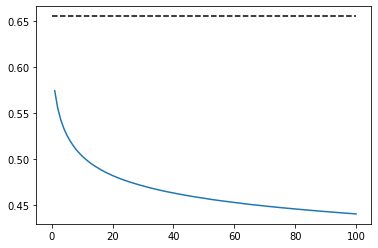

In [27]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Cossine Distance

In [28]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [29]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [30]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [31]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fa466413d50> >

In [32]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [33]:
distances, indices = index_cos.search(emb_norm, 2)

In [34]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(24680)

In [35]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [36]:
(sum(emb_norm[0] * emb_norm[411]) + 1) / 2

0.9378490136737128

In [37]:
max_k = 100
distances, indices = index_cos.search(emb_norm, max_k + 1)

In [38]:
indices

array([[     0, 111018,  57079, ...,  53055,  68917,  53514],
       [     1, 154949, 100594, ..., 103343,  21203,  41580],
       [     2, 123185, 116703, ...,  59163, 143248,  34671],
       ...,
       [169340,  17471, 120674, ..., 107049,  53645,  18312],
       [169341, 117698,  76759, ...,  19066, 129241,  73695],
       [169342,  47142,  90378, ...,  28221,  68953,  19489]])

In [39]:
sum(emb_norm[0] * emb_norm[411])

0.8756980273474255

In [40]:
distances

array([[0.99999994, 0.99938285, 0.9993823 , ..., 0.99787384, 0.99785525,
        0.9978264 ],
       [1.        , 0.999628  , 0.9795913 , ..., 0.85429984, 0.8542185 ,
        0.8535143 ],
       [1.        , 0.9995694 , 0.99827814, ..., 0.99611825, 0.99610007,
        0.996075  ],
       ...,
       [0.9999998 , 0.994864  , 0.9940955 , ..., 0.9770901 , 0.9770406 ,
        0.9770009 ],
       [1.        , 0.99937415, 0.99885684, ..., 0.99440616, 0.9944016 ,
        0.9943944 ],
       [1.0000001 , 0.94484496, 0.9296594 , ..., 0.8355224 , 0.8350331 ,
        0.83482575]], dtype=float32)

In [41]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [42]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

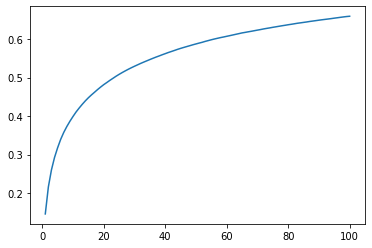

In [43]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [44]:
percentages

tensor([0.1457, 0.2159, 0.2600, 0.2923, 0.3175, 0.3394, 0.3575, 0.3728, 0.3864,
        0.3988, 0.4105, 0.4208, 0.4304, 0.4393, 0.4475, 0.4549, 0.4618, 0.4689,
        0.4754, 0.4816, 0.4872, 0.4928, 0.4981, 0.5035, 0.5084, 0.5130, 0.5174,
        0.5217, 0.5257, 0.5295, 0.5331, 0.5368, 0.5402, 0.5435, 0.5469, 0.5501,
        0.5533, 0.5562, 0.5593, 0.5622, 0.5652, 0.5678, 0.5706, 0.5734, 0.5759,
        0.5783, 0.5806, 0.5829, 0.5853, 0.5875, 0.5896, 0.5917, 0.5941, 0.5962,
        0.5983, 0.6003, 0.6022, 0.6040, 0.6056, 0.6073, 0.6090, 0.6108, 0.6126,
        0.6143, 0.6161, 0.6175, 0.6190, 0.6204, 0.6219, 0.6234, 0.6249, 0.6265,
        0.6279, 0.6292, 0.6307, 0.6320, 0.6334, 0.6347, 0.6360, 0.6374, 0.6386,
        0.6399, 0.6412, 0.6423, 0.6435, 0.6446, 0.6459, 0.6470, 0.6481, 0.6492,
        0.6503, 0.6513, 0.6523, 0.6533, 0.6545, 0.6556, 0.6567, 0.6577, 0.6587,
        0.6595])

### Percentage of same class neighbors by neighborhood size

In [45]:
ind_labels = label_transform(indices)

In [46]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [47]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [48]:
perc_same_class = n_same_class / n_total

In [49]:
perc_same_class

array([0.58402768, 0.5639619 , 0.55091146, 0.54152962, 0.53398369,
       0.52768149, 0.52248648, 0.51793992, 0.51413797, 0.51082064,
       0.50790515, 0.50509075, 0.50262258, 0.50033533, 0.49814046,
       0.49625796, 0.49434093, 0.49258474, 0.49098824, 0.48948023,
       0.48805257, 0.48677724, 0.48552886, 0.48433898, 0.48314911,
       0.48207916, 0.4810574 , 0.48006898, 0.47910882, 0.4781664 ,
       0.47728803, 0.47643688, 0.47558846, 0.47477935, 0.47403385,
       0.47327137, 0.47256017, 0.47185314, 0.47123143, 0.47057068,
       0.46997183, 0.46937661, 0.46876238, 0.4681342 , 0.4675741 ,
       0.46703372, 0.46645767, 0.46595581, 0.46543816, 0.46494984,
       0.46444361, 0.46394823, 0.46348101, 0.46302814, 0.46258573,
       0.46215658, 0.46168966, 0.46127834, 0.46088137, 0.46046279,
       0.46005648, 0.45968042, 0.45928209, 0.4588878 , 0.4585161 ,
       0.45814985, 0.45777311, 0.45739859, 0.45703605, 0.45668791,
       0.45634192, 0.45600842, 0.45563786, 0.45530764, 0.45500

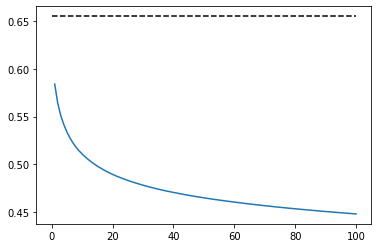

In [50]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [51]:
pca = PCA(n_components=2)

In [52]:
pca.fit(embeddings)

PCA(n_components=2)

In [53]:
emb_2d = pca.transform(embeddings)

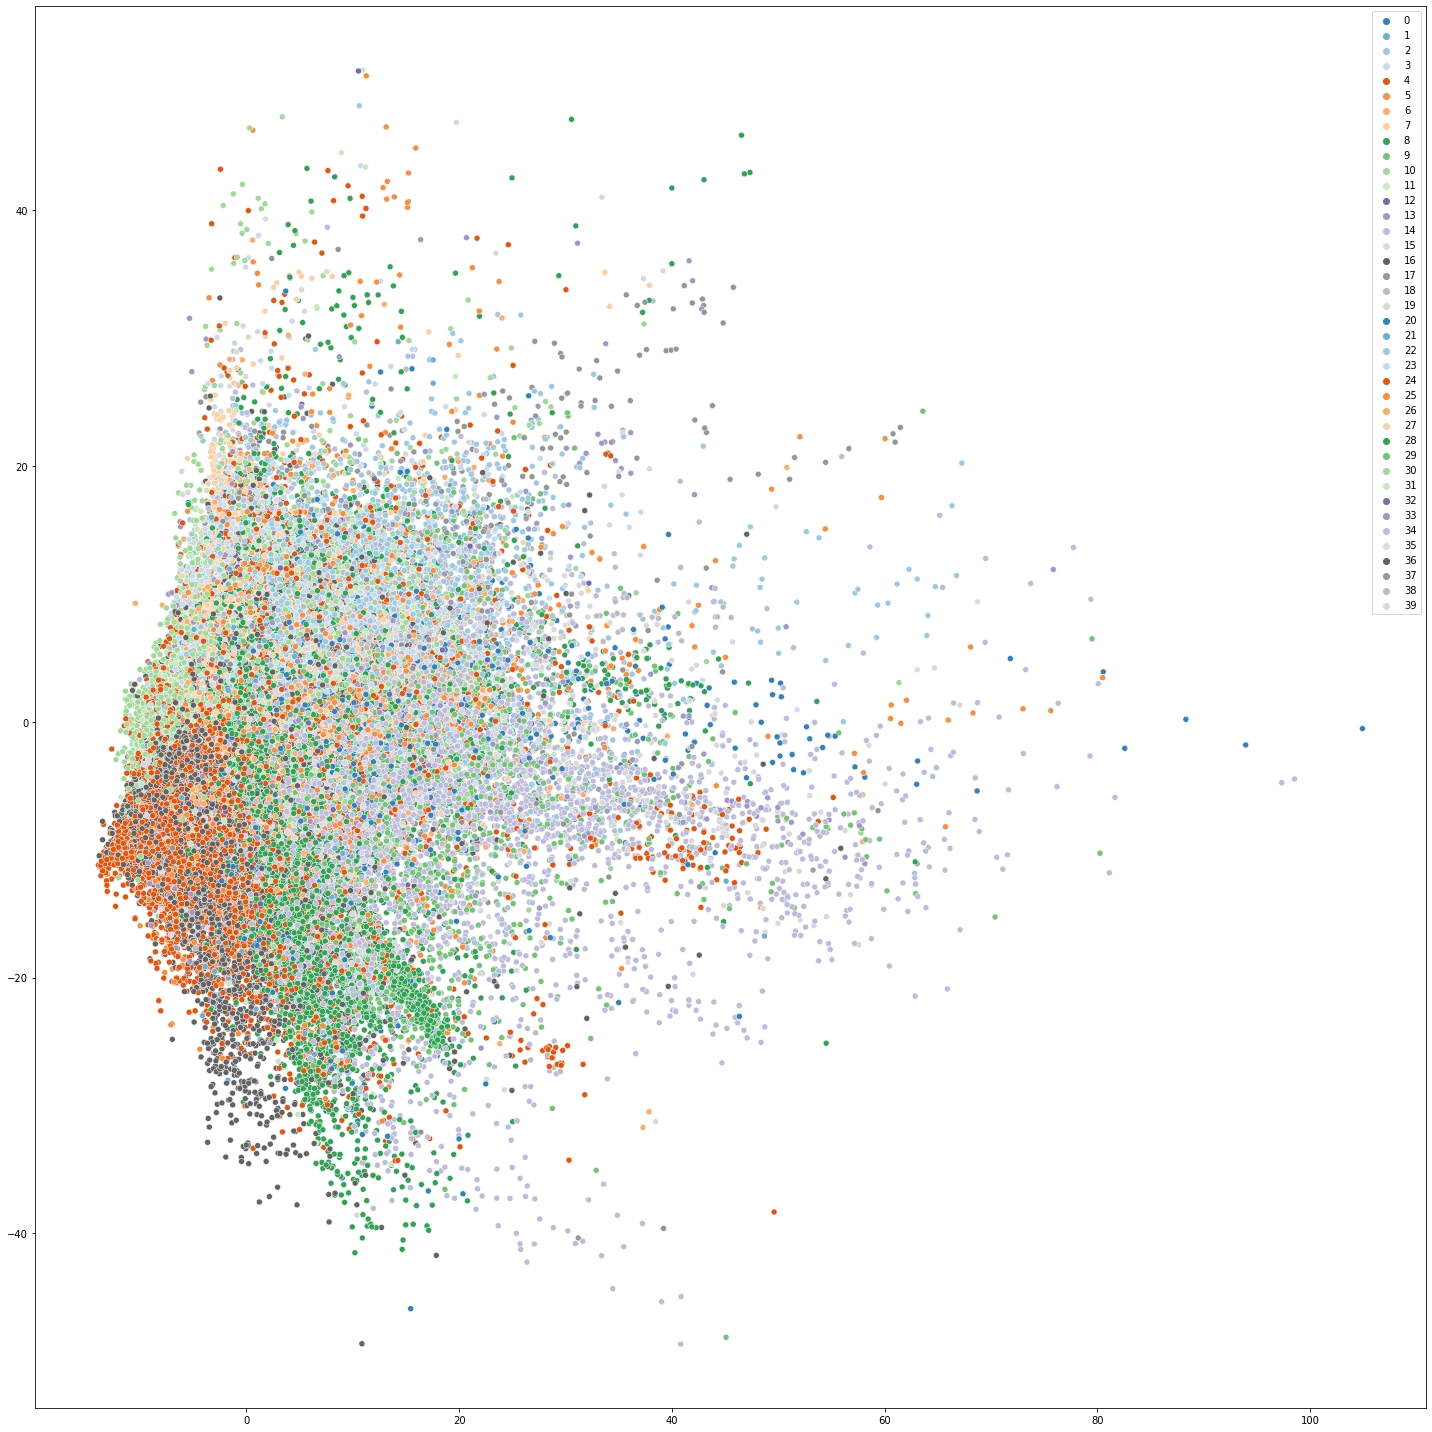

In [54]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [55]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

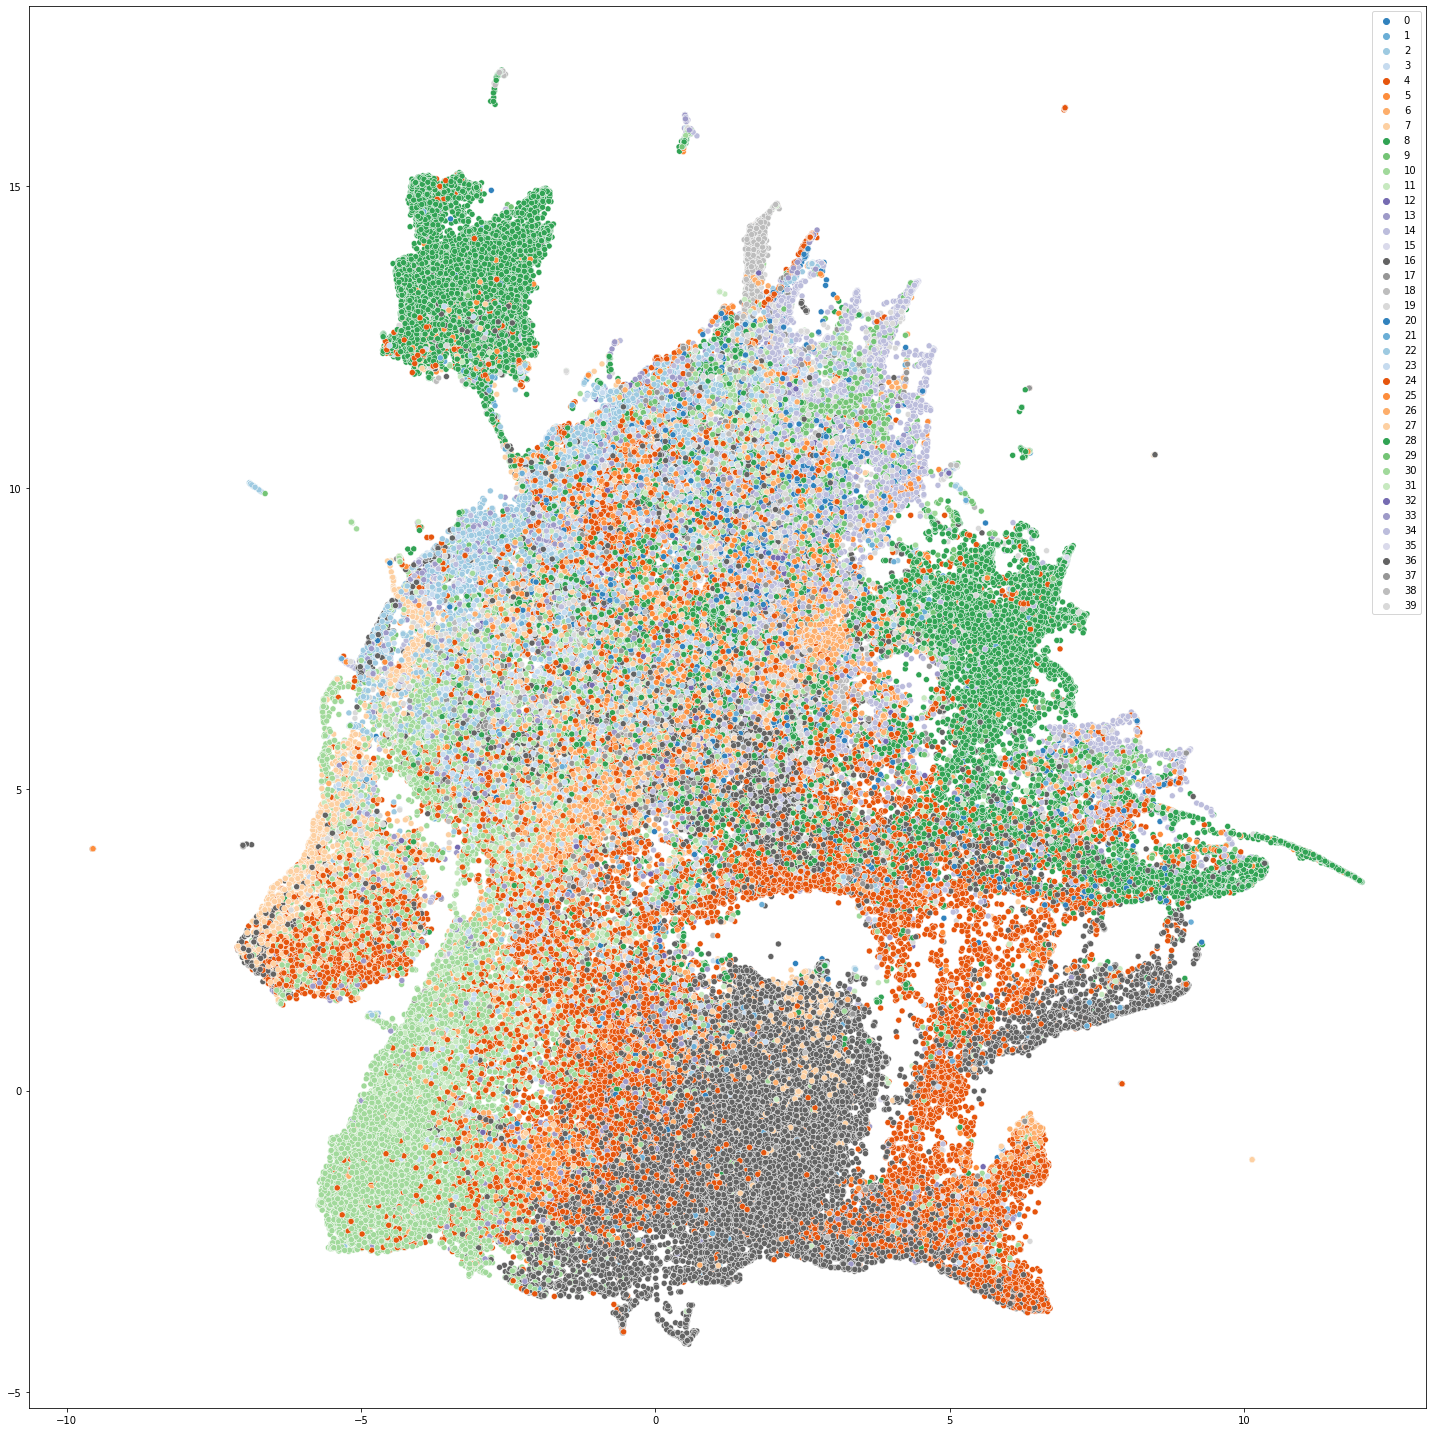

In [56]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()